# Put Pricing under the Black Scholes Model

Author: Jose Melo

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import norm
from optimizer import *
from nets import *
from fd import *
from matplotlib import cm

%matplotlib widget

DTYPE = torch.float64
DEV   = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(DTYPE)

## Parameters

In [2]:
STRIKE = 100
S_MIN, S_MAX =  1e-4, 4*STRIKE
X_MIN, X_MAX = np.log(S_MIN/STRIKE), np.log(S_MAX/STRIKE)   

T     = 1.0      # years to expiry
K     = 100.0    # strike
r     = 0.03     # risk-free (flat)
q     = 0.00     # dividend yield
SIGMA = 0.20     # volatility

In [3]:
def sample_domain(n_int=25_000, n_bdry=25_000, n_pay=25_000):
    # interior ----------------------------------------------------
    inter       = np.random.rand(n_int, 2)
    inter[:, 0] = inter[:, 0] * T                       
    inter[:, 1] = inter[:, 1]*(X_MAX-X_MIN) + X_MIN 

    # bottom boundary  x = X_MIN ------------------------------
    bot         = np.random.rand(n_bdry, 2)
    bot[:, 0]   = bot[:, 0] * T
    bot[:, 1]   = X_MIN

    # top boundary  x = X_MAX -------------------------------
    top         = np.random.rand(n_bdry, 2)
    top[:, 0]   = top[:, 0] * T
    top[:, 1]   = X_MAX

    # terminal condition  tau = 0 ------------------------------
    pay         = np.random.rand(n_pay, 2)
    pay[:, 0]   = 0.0
    pay[:, 1]   = pay[:, 1]*(X_MAX-X_MIN) + X_MIN

    X = np.vstack([inter, bot, top, pay])
    return torch.tensor(X, dtype=DTYPE, device=DEV)

In [4]:
def pde_residual(model, X):    
    X.requires_grad_(True)
    u      = model(X)
    grads  = torch.autograd.grad(u.sum(), X, create_graph=True)[0]
    u_tau, u_x  = grads[:, 0], grads[:, 1]
    u_xx        = torch.autograd.grad(u_x.sum(), X, create_graph=True)[0][:, 1]
    return -u_tau + 0.5 * SIGMA**2 * (u_xx - u_x) + r * u_x - r * u, u

def pde_loss(model, X):        
    _, x = X.t()
    H = torch.maximum(1.0 - torch.exp(x), torch.zeros_like(x))
    pde, u = pde_residual(model, X)    
    return torch.maximum(H - u, pde).pow(2).mean()

def loss_fn(model, X):
    tau, x = X.t()
    interior = (tau > 0) & (tau < T) & (x > X_MIN) & (x < X_MAX)
    bot     = x == X_MIN
    top     = x == X_MAX
    payoff  = tau == 0

    # interior
    l_int = pde_loss(model, X[interior])

    # # bottom boundary  -dV/dtau - r*V = 0
    # X_bot = X[bot].requires_grad_(True)
    # V_bot = model(X_bot)
    # Vtau_bot = torch.autograd.grad(V_bot.sum(), X_bot, create_graph=True)[0][:, 0]
    # l_bot = (-Vtau_bot - r * V_bot).pow(2).mean()

    # # top boundary  d2V/dx2 - dV/dx = 0
    # X_top = X[top].requires_grad_(True)
    # V_top = model(X_top)
    # Vx_top = torch.autograd.grad(V_top.sum(), X_top, create_graph=True)[0][:, 1]
    # Vxx_top = torch.autograd.grad(Vx_top.sum(), X_top, create_graph=True)[0][:, 1]
    # l_top = (Vxx_top - Vx_top).pow(2).mean()

    # bottom boundary  -dV/dtau - r*V = 0
    # V_top = model(X_top)
    # X_top = X[top].requires_grad_(True)
    # Vtau_top = torch.autograd.grad(V_top.sum(), X_top, create_graph=True)[0][:, 0]
    # l_top = (-Vtau_top - r * V_top).pow(2).mean()
    V_top = model(X[top])
    l_top = V_top.pow(2).mean()

    # top boundary  d2V/dx2 - dV/dx = 0
    X_bot = X[bot].requires_grad_(True)
    V_bot = model(X_bot)
    Vx_bot = torch.autograd.grad(V_bot.sum(), X_bot, create_graph=True)[0][:, 1]
    Vxx_bot = torch.autograd.grad(Vx_bot.sum(), X_bot, create_graph=True)[0][:, 1]
    l_bot = (Vxx_bot - Vx_bot).pow(2).mean()


    # payoff
    x_pay = x[payoff]
    payoff_val = torch.maximum(1.0 - torch.exp(x_pay), torch.zeros_like(x_pay))
    l_pay = (model(X[payoff]) - payoff_val).pow(2).mean()

    print("loss int {:8.2e}  bot {:8.2e}  top {:8.2e}  pay {:8.2e}".format(l_int.item(), l_bot.item(), l_top.item(), l_pay.item()))
    return l_int + l_bot + l_top + l_pay

## Training

In [5]:
X = sample_domain()

In [6]:
model = MLP(in_dim=2, hidden_layers=[20, 20], out_dim=1).to(DEV)
for p in model.parameters():
    if p.dim()>1: nn.init.xavier_uniform_(p)

In [137]:
opt = SSBroyden(model.parameters(), max_iter=20_000, tolerance_change=1e-10, tolerance_grad=1e-10)

losses = []
def closure(*args, **kwargs):
    opt.zero_grad()
    loss = loss_fn(model, X)
    loss.backward()
    losses.append(loss.item())
    return loss

opt.step(closure)
print("training finished")

loss int 1.67e+00  bot 1.50e-04  top 4.39e-01  pay 1.64e+00
loss int 1.37e-01  bot 2.26e-02  top 6.13e-02  pay 2.90e-01
loss int 1.37e-01  bot 2.26e-02  top 6.13e-02  pay 2.90e-01
loss int 1.31e-01  bot 2.17e-02  top 5.06e-02  pay 2.77e-01
loss int 8.56e-02  bot 1.42e-02  top 5.21e-04  pay 1.75e-01
loss int 8.56e-02  bot 1.42e-02  top 5.21e-04  pay 1.75e-01
loss int 8.14e-02  bot 1.22e-02  top 6.33e-04  pay 1.60e-01
loss int 6.08e-02  bot 7.93e-04  top 1.99e-03  pay 5.51e-02
loss int 6.08e-02  bot 7.93e-04  top 1.99e-03  pay 5.51e-02
loss int 6.01e-02  bot 7.68e-04  top 1.96e-03  pay 5.45e-02
loss int 5.44e-02  bot 5.59e-04  top 1.76e-03  pay 4.89e-02
loss int 1.24e-02  bot 1.07e-04  top 2.96e-04  pay 1.82e-02
loss int 1.24e-02  bot 1.07e-04  top 2.96e-04  pay 1.82e-02
loss int 1.23e-02  bot 1.15e-04  top 2.91e-04  pay 1.79e-02
loss int 1.17e-02  bot 2.00e-04  top 2.58e-04  pay 1.56e-02
loss int 1.17e-02  bot 2.00e-04  top 2.58e-04  pay 1.56e-02
loss int 1.17e-02  bot 2.03e-04  top 2.5

In [138]:
torch.save(model.state_dict(), "american.pt")

In [7]:
model.load_state_dict(torch.load("american.pt"))

<All keys matched successfully>

In [8]:
model.eval()
with torch.no_grad():
    tau = torch.linspace(0, T, 100, device=DEV)
    x = torch.linspace(X_MIN, X_MAX, 100, device=DEV)
    t = (1-tau)*T
    s = STRIKE * torch.exp(x)
    tau, x = torch.meshgrid(tau, x, indexing="ij")

    x = torch.stack([tau.reshape(-1), x.reshape(-1)], dim=1)
    u = model(x).reshape(tau.shape)
    v = u*STRIKE


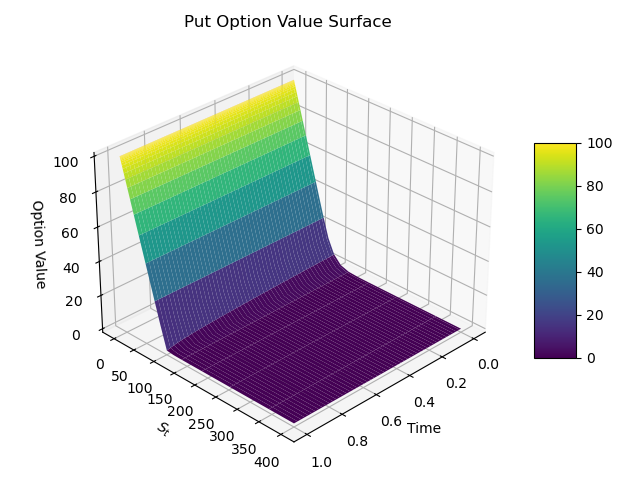

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tt, ss = np.meshgrid(t, s, indexing='ij')

surf = ax.plot_surface(tt, ss, v.cpu().numpy(),
                       cmap='viridis', edgecolor='none')

ax.set_xlabel('Time')
ax.set_ylabel('$S_t$')
ax.set_zlabel('Option Value')
ax.set_title('Put Option Value Surface')

# Rotate the view - adjust elevation and azimuth angles
ax.view_init(elev=30, azim=45)

plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

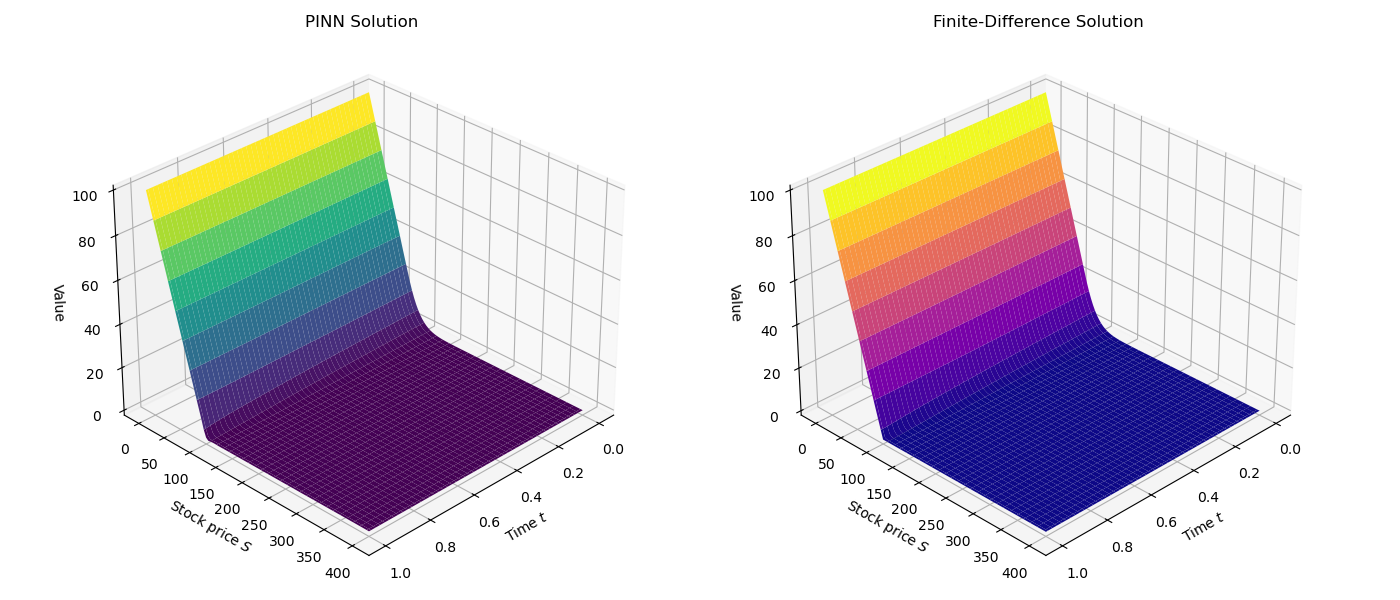

In [16]:
nas = 100                                            # space steps
v_fd, s_fd, t_fd = option_value_fd_american(SIGMA, r,
                                            STRIKE, T,
                                            option_type='put',
                                            nas=nas)
v_fd = np.flipud(v_fd.T)                                       # shape (nt, ns)

# ───────────────────────── 2)  PINN on the same grid ─────────────────
tau_grid  = 1.0 - torch.tensor(t_fd, dtype=DTYPE, device=DEV) / T
S_grid_t  = torch.tensor(s_fd, dtype=DTYPE, device=DEV)
tau, S      = torch.meshgrid(tau_grid, S_grid_t, indexing='ij')
x_grid    = torch.log(S / STRIKE)

with torch.no_grad():
    Xg          = torch.stack([tau.reshape(-1), x_grid.reshape(-1)], dim=1)
    V_pinn_grid = model(Xg).reshape(tau.shape) * STRIKE

# convert to NumPy for plotting
V_pinn_np = V_pinn_grid.cpu().numpy()
err_np    = np.abs(V_pinn_np - v_fd)                 # |error|
TT, SS    = np.meshgrid(t_fd, s_fd, indexing='ij')   # for 3-D axes

# ───────────────────────── 3)  FIGURE 1 – two surfaces ──────────────
fig1 = plt.figure(figsize=(14, 6))

# (a) PINN surface ----------------------------------------------------
ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(TT, SS, V_pinn_np, cmap=cm.viridis, edgecolor='none')
ax1.set_title('PINN Solution')
ax1.set_xlabel('Time $t$'); ax1.set_ylabel('Stock price $S$'); ax1.set_zlabel('Value')
ax1.view_init(elev=30, azim=45)

# (b) FD surface ------------------------------------------------------
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(TT, SS, v_fd,
                         cmap=cm.plasma, edgecolor='none')
ax2.set_title('Finite-Difference Solution')
ax2.set_xlabel('Time $t$'); ax2.set_ylabel('Stock price $S$'); ax2.set_zlabel('Value')
ax2.view_init(elev=30, azim=45)

fig1.tight_layout()
plt.show()

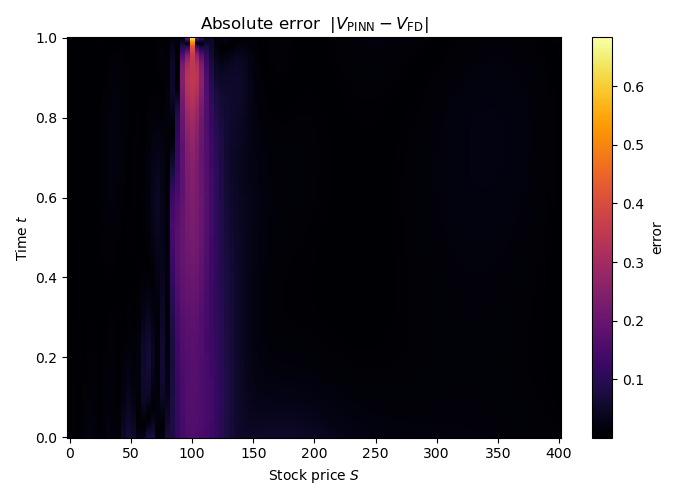

In [ ]:
# ───────────────────────── 4)  FIGURE 2 – error heat-map ────────────
fig2, ax_err = plt.subplots(figsize=(7, 5))
pcm = ax_err.pcolormesh(SS, TT, err_np,
                        shading='auto', cmap='inferno')
ax_err.set_title(r'Absolute Error  $|V_{\mathrm{PINN}}-V_{\mathrm{FD}}|$')
ax_err.set_xlabel('Stock price $S$')
ax_err.set_ylabel('Time $t$')
fig2.colorbar(pcm, ax=ax_err, label='Error')
fig2.tight_layout()
plt.show()

In [12]:
np.linalg.norm(err_np, 2) / np.linalg.norm(v_fd, 2)  # relative L2 error

np.float64(0.0018841459097749273)